In [3]:
# Import the required libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

Loading dataset and add headers

In [4]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('Dataset-001.csv', names=columns)

In [5]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,B00ZGTMHVU,A1HGH7NF01K3W7,5.0,1451001600
1,B013CG1EVC,A3GDQGSD4C0HOB,5.0,1496966400
2,B013CG1EVC,A1C88HIIEVN0QN,5.0,1445904000
3,B013CG1EVC,A1G5MTDE3A5LSL,5.0,1440892800
4,B013CG1XS6,A3SOHSDN51M5NQ,5.0,1441497600


In [6]:
# Removing the timestamp column
electronics_df.drop('timestamp',axis=1,inplace=True)

In [7]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233055327 entries, 0 to 233055326
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 5.2+ GB


In [8]:
# Check the number of rows and columns
rows, columns = electronics_df.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  233055327
Number of columns:  3


In [9]:
# Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [10]:
# Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:] 

In [11]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [12]:
# Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()


count    50000.000000
mean         3.854340
std          1.536441
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [13]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

#~ Rating scale is from 1 to 5

Minimum rating is: 1
Maximum rating is: 5


In [14]:
# Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


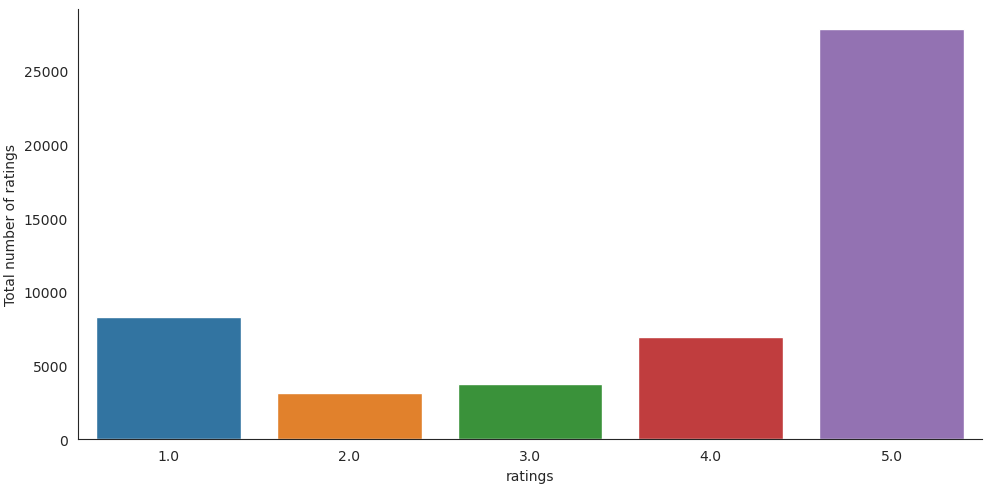

In [17]:
import seaborn as sns

# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="ratings", data=electronics_df1, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings") 


In [29]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  1122
Number of unique product in Raw data =  47298


In [30]:
# Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
1620213982    4782
B00005JS5C    2239
B000050FDY    1528
B017OBSCOS    1180
B000EG8HLE    1054
B01DJCJTZ2     956
B01EIQX6Y8     954
B000BJ1CGQ     948
B00011QUDE     939
B01BMUU6JQ     847
dtype: int64


In [54]:
counts = electronics_df1.userId.value_counts()
electronics_df1_final = electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items = ', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

#~ electronics_df1_final has the users who have rated 25 or more different items

Number of users who have rated 25 or more items =  46310
Number of unique users in the final data =  319
Number of unique products in the final data =  319


In [60]:
electronics_df1_final_no_duplicates = electronics_df1_final.drop_duplicates()

In [61]:
print("DataFrame without duplicates across all columns:")
print(electronics_df1_final_no_duplicates)

DataFrame without duplicates across all columns:
           userId       productId  ratings
5      B0096E8EPY   AYRFEPLLS7A7O      3.0
6      B0096E8EPY   A7WT61P4D6W0H      1.0
7      B0096E8EPY  A2KH4WTPYWYQST      4.0
8      B0096E8EPY  A204ETWOV23HO4      3.0
9      B0096E8EPY  A1XT4N33B6MOP9      5.0
...           ...             ...      ...
49995  B000EG8HLE  A2LOVPOMVWW9M3      5.0
49996  B000EG8HLE   AHFSBLJFOO6WG      5.0
49997  B000EG8HLE   A4Z5JK1HY1HM6      1.0
49998  B000EG8HLE  A1BVTBDOS8HWK7      5.0
49999  B000EG8HLE  A1YNBS97C8NNPG      5.0

[46234 rows x 3 columns]


In [62]:
duplicates_df = electronics_df1_final.duplicated()
print("Duplicate rows:")
print(electronics_df1_final[duplicates_df])

Duplicate rows:
           userId       productId  ratings
27169  1620213982   AD80MGOY5CJZ4      5.0
30057  B000052YAN   ACTVXNBEPLW2S      4.0
30096  B0000530HU  A2CTM1BYAXTYLX      5.0
30318  B0000530HU  A3AMP8ZS2WQ94N      5.0
30398  B0000530HU  A3IUZTFFQM3H31      5.0
...           ...             ...      ...
48903  B000EE9XYG  A2DX0XVAABFBMB      5.0
48907  B000EE9XYG  A1MERXJG4WTQKJ      5.0
48922  B000EE9XYG  A122G4SAY6HEEI      5.0
48924  B000EE9XYG   ACC5DH3WUH5QT      5.0
48939  B000EE9XYG   AH3ZYLAXKPNVT      5.0

[76 rows x 3 columns]


In [64]:
electronics_df1_final = electronics_df1_final_no_duplicates

In [65]:
electronics_df1_final


,userId,productId,ratings
5,B0096E8EPY,AYRFEPLLS7A7O,3.0
6,B0096E8EPY,A7WT61P4D6W0H,1.0
7,B0096E8EPY,A2KH4WTPYWYQST,4.0
8,B0096E8EPY,A204ETWOV23HO4,3.0
9,B0096E8EPY,A1XT4N33B6MOP9,5.0
...,...,...,...
49995,B000EG8HLE,A2LOVPOMVWW9M3,5.0
49996,B000EG8HLE,AHFSBLJFOO6WG,5.0
49997,B000EG8HLE,A4Z5JK1HY1HM6,1.0
49998,B000EG8HLE,A1BVTBDOS8HWK7,5.0


In [70]:
import pandas as pd

# Assuming you have imported pandas and the DataFrame is named electronics_df1_final

# Method 2: Aggregate data based on 'userId' and 'productId'
aggregated_df = electronics_df1_final.groupby(['userId', 'productId'])['ratings'].mean().reset_index()

# Constructing the pivot table
final_ratings_matrix = aggregated_df.pivot(index='userId', columns='productId', values='ratings').fillna(0)
final_ratings_matrix.head()


productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
userId,,,,,,,,,,,,,,,,,,,,,
1620213982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5874700021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790787006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B6B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (319, 44549)


In [72]:
# Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

#~ If density comes out to be less than 20%, then it will be a sparse matrix

given_num_of_ratings =  46212
possible_num_of_ratings =  14211131
density: 0.33%


In [73]:
# Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
24745,1620213982,A1PBFPSWO13WZ5,5.0
48679,B000EE9XYG,AACTA0VN291VP,4.0
14807,B01FGS66D0,A28CYTBXJMWI7R,5.0
36315,B000146LKS,A3SKDH4EP6W939,3.0
29834,B000050FDY,AIVF0AFNQLQJT,5.0


In [74]:
print('Shape of training data: ', train_data.shape)
print('Shape of testing data: ', test_data.shape)

Shape of training data:  (32363, 3)
Shape of testing data:  (13871, 3)


In [75]:
# Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'}, inplace=True)
train_data_grouped.head(40)

,productId,score
0,A00408825PVJW7GFLEGU,1
1,A00891833ZVXH5O654HE,1
2,A0096681Y127OL1H8W3U,1
3,A0334215VCM8PD19KOP3,1
4,A035675510L7VD5NUTJS,1
5,A0376717ZUMCEEOJACT2,1
6,A0488385844WNV2OWO9X,1
7,A0611551KU79JNSC7JJV,1
8,A0894093QU08VYIOAIEL,1
9,A1002YFK94CBR6,1


In [76]:
#~ Generating the recommendation order

# Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
# Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
5470,A1O35FYKDTF5Z9,17,1.0
11586,A2E22B6U6A4NQK,16,2.0
16178,A2Y8D7OG18GERD,13,3.0
25598,AAT47MLSLM5CQ,8,4.0
26280,ADHIKYHPT6HR5,8,5.0


In [77]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    # Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    # Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [78]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")
    
#~ Since, it is a Popularity recommender model, so, all the three users are given the same recommendations.
#~ Here, we predict the products based on the popularity. It is not personalized to particular user.
#~ It is a non-personalized recommender system.

The list of recommendations for the userId: 10

       userId       productId  score  rank
5470       10  A1O35FYKDTF5Z9     17   1.0
11586      10  A2E22B6U6A4NQK     16   2.0
16178      10  A2Y8D7OG18GERD     13   3.0
25598      10   AAT47MLSLM5CQ      8   4.0
26280      10   ADHIKYHPT6HR5      8   5.0


The list of recommendations for the userId: 100

       userId       productId  score  rank
5470      100  A1O35FYKDTF5Z9     17   1.0
11586     100  A2E22B6U6A4NQK     16   2.0
16178     100  A2Y8D7OG18GERD     13   3.0
25598     100   AAT47MLSLM5CQ      8   4.0
26280     100   ADHIKYHPT6HR5      8   5.0


The list of recommendations for the userId: 150

       userId       productId  score  rank
5470      150  A1O35FYKDTF5Z9     17   1.0
11586     150  A2E22B6U6A4NQK     16   2.0
16178     150  A2Y8D7OG18GERD     13   3.0
25598     150   AAT47MLSLM5CQ      8   4.0
26280     150   ADHIKYHPT6HR5      8   5.0




In [79]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,24745,1620213982,A1PBFPSWO13WZ5,5.0
1,48679,B000EE9XYG,AACTA0VN291VP,4.0
2,14807,B01FGS66D0,A28CYTBXJMWI7R,5.0
3,36315,B000146LKS,A3SKDH4EP6W939,3.0
4,29834,B000050FDY,AIVF0AFNQLQJT,5.0


In [81]:
import pandas as pd

# Assuming you have imported pandas and the DataFrame is named electronics_df_CF

# Method 2: Aggregate data based on 'userId' and 'productId'
aggregated_df = electronics_df_CF.groupby(['userId', 'productId'])['ratings'].mean().reset_index()

# Constructing the pivot table
pivot_df = aggregated_df.pivot(index='userId', columns='productId', values='ratings').fillna(0)
pivot_df.head()


productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
userId,,,,,,,,,,,,,,,,,,,,,
1620213982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5874700021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790787006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B6B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (319, 44549)


In [83]:
# Define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G,user_index
userId,,,,,,,,,,,,,,,,,,,,,
1620213982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5874700021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9790787006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
B000050B65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
B000050B6B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [84]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

#~ As this matrix is a sparse matrix, we will be using Singular Value Decomposition

productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

# Assuming you have imported pandas, numpy, and the pivot_df DataFrame

# Convert pivot_df to a NumPy array for SVD
pivot_df_array = pivot_df.to_numpy()

# Perform SVD with k=10
U, sigma, Vt = svds(pivot_df_array, k=10)

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)


In [87]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.49535234e-04  1.96296338e-05 -5.00598710e-07 ... -3.93327121e-04
  -7.13393801e-04  9.99994584e-01]
 [-7.02854152e-19  1.37946579e-23  2.34213402e-18 ... -2.57841238e-17
   1.16524268e-17  1.51271518e-17]
 [-2.04870196e-17 -2.15528354e-17 -1.02546932e-23 ...  5.26028780e-17
  -2.53671221e-18 -3.62762896e-17]
 ...
 [ 2.88755752e-06 -3.01642790e-07  7.95445194e-09 ...  6.16261081e-10
   1.44042920e-09  6.40404376e-09]
 [ 4.85848445e-04 -5.74157262e-05 -1.27084132e-06 ...  3.17425004e-06
   7.43769132e-07  7.86452727e-07]
 [-1.06538450e-06  2.01054111e-07 -4.69728221e-09 ...  3.01900154e-12
   1.05110241e-12  1.56997395e-11]]


In [88]:
print('Sigma: \n',sigma)
#~ As sigma is not a diagonal matrix, we have to convert it into a diagonal one

Sigma: 
 [[128.81031997   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         129.00517735   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         129.00581361   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         131.11570014   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         133.84561859
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  136.37180016   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         137.0182534    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.         184.471

In [89]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)              # Matrix transformation function
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [128.81031997 129.00517735 129.00581361 131.11570014 133.84561859
 136.37180016 137.0182534  184.471927   203.81938859 334.34574463]


In [90]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-1.85824498e-07  1.52069479e-02 -3.42303092e-07 ...  1.01185735e-05
   8.70711196e-05  2.48446531e-07]
 [ 8.90310278e-08 -1.71607389e-03  8.21714764e-08 ... -1.11318155e-06
  -4.54345272e-07 -7.18293685e-10]
 [-2.57089034e-09  4.75063909e-05 -1.37448421e-09 ...  1.09147823e-08
  -8.79500370e-08 -3.32289860e-09]
 ...
 [ 4.81122379e-11  3.88607731e-08  2.71038337e-02 ...  5.00017240e-09
   8.65649155e-09  3.03044013e-11]
 [ 2.06989669e-11  1.43582072e-08  6.52767012e-05 ...  2.37225366e-10
   7.02687279e-09 -3.17214249e-12]
 [ 9.74958395e-10  2.54124764e-06  5.80416903e-06 ...  5.64048738e-10
   4.48483489e-09  1.38281975e-09]]


In [92]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

# Assuming you have imported pandas, numpy, and the pivot_df DataFrame

# Convert pivot_df to a NumPy array for SVD
pivot_df_array = pivot_df.to_numpy()

# Perform SVD with k=10
U, sigma, Vt = svds(pivot_df_array, k=10)

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

# Calculate predicted ratings using SVD
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert predicted ratings to a DataFrame
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=pivot_df.columns)
preds_df.head()


productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
0,2.567249e-07,-8.204627e-05,-3.545078e-05,-2.326294e-15,-2.348615e-08,-7.493740e-07,-2.608941e-07,-1.665692e-06,-1.366681e-06,1.166470e-03,...,3.561437e-07,7.006683e-04,3.561437e-07,1.205162e-07,-1.284660e-16,5.476032e-08,7.006683e-04,-4.402179e-07,-1.511027e-05,4.191310e-07
1,-5.040036e-21,-1.914152e-16,2.451376e-16,-9.634937e-32,-3.215800e-22,5.875260e-20,-1.451553e-20,5.754242e-19,1.785538e-16,7.143430e-20,...,3.622700e-19,-1.821778e-18,3.622700e-19,-5.373002e-22,-4.143928e-32,-6.891897e-22,-1.821778e-18,-1.279811e-19,-1.794188e-18,-5.645064e-21
2,4.614896e-21,1.092613e-16,-8.277087e-17,4.464191e-31,2.908885e-21,-4.193335e-20,-5.818464e-20,-1.145744e-16,-1.800561e-17,-1.862217e-19,...,1.135629e-16,1.239027e-18,1.135629e-16,-3.311861e-22,2.626355e-32,1.106544e-21,1.239027e-18,7.298815e-20,5.506705e-19,3.796772e-21
3,-4.524217e-10,-1.762196e-07,3.725795e-03,-1.840318e-19,-6.335158e-10,-1.361586e-09,1.364003e-08,6.719420e-09,-1.821160e-06,-9.956120e-10,...,-3.209844e-07,-5.996925e-08,-3.209844e-07,1.044594e-09,-1.418893e-19,-1.841157e-10,-5.996925e-08,5.516089e-10,8.350079e-08,-1.531519e-10
4,-4.195489e-10,-1.248929e-07,5.321326e-06,-1.122962e-19,-5.715567e-10,8.034468e-11,1.203417e-08,2.263927e-09,2.466841e-07,1.046791e-10,...,-2.882528e-07,-6.052819e-08,-2.882528e-07,1.225801e-10,-9.683297e-22,-1.706378e-10,-6.052819e-08,-9.673942e-11,7.131834e-08,-1.431368e-10


In [93]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    # sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    # sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [94]:
# Recommended items for user with user_id = 4
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
A3RX2SPLAXUFZH              0.0          0.003743
A1CYTBE7LLUQ8F              0.0          0.003743
ABRLIXG3M9EBQ               0.0          0.003743
A1NLVZ80ZWXKPR              0.0          0.003743
ABPNZ9RKXOP0E               0.0          0.003738


In [95]:
# Below are the recommended items for user with user_id = 6
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
A31DZCIN65HLQ               0.0      5.144346e-16
A31IK0KTCXZQQJ              0.0      5.144346e-16
A2HOY6QELA5OE9              0.0      5.144346e-16
A2SMIV3471VREV              0.0      5.144346e-16
A1QYV12AWOKQ66              0.0      5.144346e-16


In [96]:
# Below are the recommended items for user with user_id = 8
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

#~ Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
ALXDO8XT8ACQ1               0.0      4.993999e-09
A2T7ATHKZOELPE              0.0      4.986908e-09
A18EWGX26RJ1A7              0.0      4.693892e-09
A1DSGFP0T0OU1G              0.0      4.375763e-09
A1RBNR2LC0O0R3              0.0      3.989526e-09


In [97]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
userId,,,,,,,,,,,,,,,,,,,,,
1620213982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5874700021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790787006,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B6B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
A00408825PVJW7GFLEGU    0.015674
A00891833ZVXH5O654HE    0.012539
A0096681Y127OL1H8W3U    0.015674
A0203113HC2KF1AHJHOV    0.015674
A0334215VCM8PD19KOP3    0.003135
dtype: float64

In [99]:
# Predicted ratings 
preds_df.head()

productId,A00408825PVJW7GFLEGU,A00891833ZVXH5O654HE,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0334215VCM8PD19KOP3,A035675510L7VD5NUTJS,A0376717ZUMCEEOJACT2,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0748001AYYPDBYVKQOK,...,AZYS0DWRRES6X,AZZ04DWRJ1WFV,AZZ0Z2J4VBNQH,AZZ72JCASB5WL,AZZ8N5REH7J98,AZZAC9CGC5R94,AZZFZ9UHUWCY6,AZZGMLO49VXBM,AZZNK89PXD006,AZZRXE11AE04G
0,2.567249e-07,-8.204627e-05,-3.545078e-05,-2.326294e-15,-2.348615e-08,-7.493740e-07,-2.608941e-07,-1.665692e-06,-1.366681e-06,1.166470e-03,...,3.561437e-07,7.006683e-04,3.561437e-07,1.205162e-07,-1.284660e-16,5.476032e-08,7.006683e-04,-4.402179e-07,-1.511027e-05,4.191310e-07
1,-5.040036e-21,-1.914152e-16,2.451376e-16,-9.634937e-32,-3.215800e-22,5.875260e-20,-1.451553e-20,5.754242e-19,1.785538e-16,7.143430e-20,...,3.622700e-19,-1.821778e-18,3.622700e-19,-5.373002e-22,-4.143928e-32,-6.891897e-22,-1.821778e-18,-1.279811e-19,-1.794188e-18,-5.645064e-21
2,4.614896e-21,1.092613e-16,-8.277087e-17,4.464191e-31,2.908885e-21,-4.193335e-20,-5.818464e-20,-1.145744e-16,-1.800561e-17,-1.862217e-19,...,1.135629e-16,1.239027e-18,1.135629e-16,-3.311861e-22,2.626355e-32,1.106544e-21,1.239027e-18,7.298815e-20,5.506705e-19,3.796772e-21
3,-4.524217e-10,-1.762196e-07,3.725795e-03,-1.840318e-19,-6.335158e-10,-1.361586e-09,1.364003e-08,6.719420e-09,-1.821160e-06,-9.956120e-10,...,-3.209844e-07,-5.996925e-08,-3.209844e-07,1.044594e-09,-1.418893e-19,-1.841157e-10,-5.996925e-08,5.516089e-10,8.350079e-08,-1.531519e-10
4,-4.195489e-10,-1.248929e-07,5.321326e-06,-1.122962e-19,-5.715567e-10,8.034468e-11,1.203417e-08,2.263927e-09,2.466841e-07,1.046791e-10,...,-2.882528e-07,-6.052819e-08,-2.882528e-07,1.225801e-10,-9.683297e-22,-1.706378e-10,-6.052819e-08,-9.673942e-11,7.131834e-08,-1.431368e-10


In [100]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
A00408825PVJW7GFLEGU    1.865364e-06
A00891833ZVXH5O654HE    1.619318e-02
A0096681Y127OL1H8W3U    1.590622e-02
A0203113HC2KF1AHJHOV   -1.053607e-16
A0334215VCM8PD19KOP3    1.104899e-06
dtype: float64

In [101]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(44549, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
A00408825PVJW7GFLEGU,0.015674,1.865364e-06,0
A00891833ZVXH5O654HE,0.012539,1.619318e-02,1
A0096681Y127OL1H8W3U,0.015674,1.590622e-02,2
A0203113HC2KF1AHJHOV,0.015674,-1.053607e-16,3
A0334215VCM8PD19KOP3,0.003135,1.104899e-06,4


In [102]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01091 



In [103]:
# Enter 'userID' and 'num_recommendations' for the user
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)
# Below are the recommended items for user(user_id = 9):


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
AOP0KXHDS2CXU               0.0          0.040043
A1W8P9NXUTJI76              0.0          0.033508
A3EVZ9WTE55FLS              0.0          0.022518
A2PKZWKWRE605I              0.0          0.022518
AKXQFBCVB3FR7               0.0          0.022518
